In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## 1. CARGA Y PREPROCESAMIENTO DE DATOS 

In [9]:

base_dir = 'images'
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'), target_size=target_size, batch_size=32, class_mode='binary')
val = test_datagen.flow_from_directory(os.path.join(base_dir, 'validation'), target_size=target_size, batch_size=32, class_mode='binary')
test = test_datagen.flow_from_directory(os.path.join(base_dir, 'test'), target_size=target_size, batch_size=32, class_mode='binary', shuffle=False)

Found 1492 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


## 2. MODELO CON EfficientNetB0

In [10]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

## 3. ENTRENAMIENTO 


In [20]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
47/47 [==============================] - 40s 794ms/step - loss: 0.6819 - accuracy: 0.5664 - val_loss: 0.6837 - val_accuracy: 0.5943
Epoch 2/15
47/47 [==============================] - 37s 786ms/step - loss: 0.6866 - accuracy: 0.5516 - val_loss: 0.7009 - val_accuracy: 0.4906
Epoch 3/15
47/47 [==============================] - 38s 797ms/step - loss: 0.6874 - accuracy: 0.5529 - val_loss: 0.6994 - val_accuracy: 0.5377
Epoch 4/15
47/47 [==============================] - 37s 775ms/step - loss: 0.6790 - accuracy: 0.5751 - val_loss: 0.6825 - val_accuracy: 0.5660
Epoch 5/15
47/47 [==============================] - 37s 783ms/step - loss: 0.6781 - accuracy: 0.5637 - val_loss: 0.7324 - val_accuracy: 0.4434
Epoch 6/15
47/47 [==============================] - 37s 778ms/step - loss: 0.6894 - accuracy: 0.5469 - val_loss: 0.7171 - val_accuracy: 0.4717
Epoch 7/15
47/47 [==============================] - 37s 783ms/step - loss: 0.6902 - accuracy: 0.5369 - val_loss: 0.6845 - val_accuracy: 0.5660

## 4. MATRIZ DE CONFUSIÓN Y REPORTE 

4/4 [==============================] - 2s 238ms/step


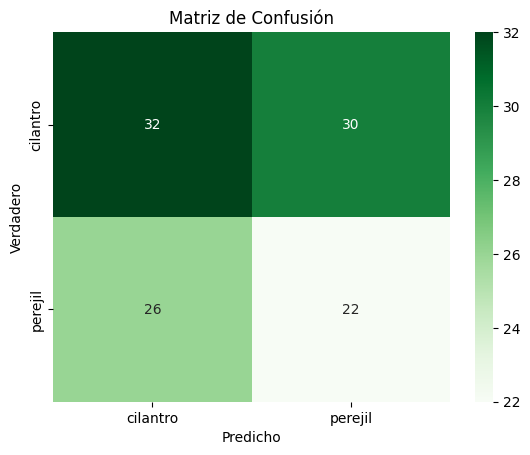

📊 Reporte de clasificación:
              precision    recall  f1-score   support

    cilantro       0.55      0.52      0.53        62
     perejil       0.42      0.46      0.44        48

    accuracy                           0.49       110
   macro avg       0.49      0.49      0.49       110
weighted avg       0.50      0.49      0.49       110



In [21]:
y_true = test.classes
y_pred_probs = model.predict(test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

labels = list(test.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.show()

print("📊 Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))

## 6. GRÁFICAS 

4/4 [==============================] - 1s 236ms/step - loss: 0.7025 - accuracy: 0.5091


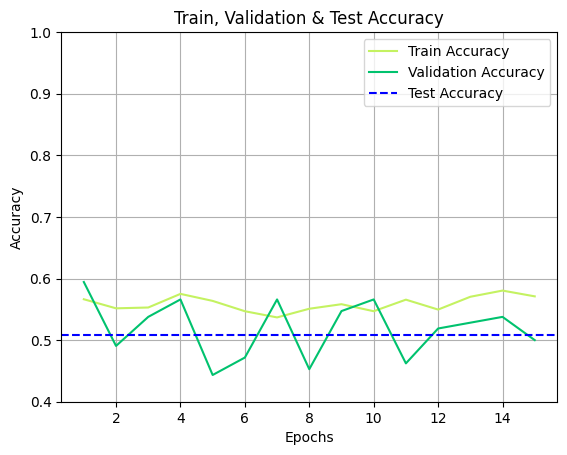

4/4 [==============================] - 1s 244ms/step - loss: 0.7075 - accuracy: 0.5182


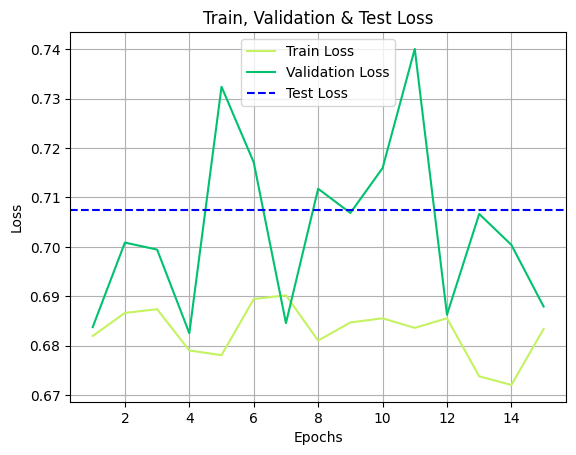

In [22]:
# === Evaluación en test ===
test_loss, test_acc = model.evaluate(test)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# === Accuracy Plot ===
plt.figure()
plt.plot(epochs, accuracy, color='#C4F261', label='Train Accuracy')
plt.plot(epochs, val_accuracy, color='#00C26E', label='Validation Accuracy')
plt.axhline(y=test_acc, color='blue', linestyle='--', label='Test Accuracy')
plt.title('Train, Validation & Test Accuracy')
plt.ylim(0.4, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# === Loss Plot ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss = model.evaluate(test)[0]

plt.figure()
plt.plot(epochs, train_loss, color='#C4F261', label='Train Loss')  
plt.plot(epochs, val_loss, color='#00C26E', label='Validation Loss')     
plt.axhline(y=test_loss, color='blue', linestyle='--', label='Test Loss')
plt.title('Train, Validation & Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## 7. GUARDAR 

In [23]:
# Option 1: Save without optimizer (for SavedModel)
model.save('modelo_entrenado_inference', save_format='tf', include_optimizer=False)

# Option 2: Save in .keras format (best for Keras 3)
model.save('modelo_entrenado.keras')

INFO:tensorflow:Assets written to: modelo_entrenado_inference/assets


INFO:tensorflow:Assets written to: modelo_entrenado_inference/assets


## 8. CARGAR MODELO

In [25]:
from tensorflow.keras.models import load_model
model = load_model('modelo_entrenado_inference')